# Testing the Bool Parser

In [1]:
import sys
sys.path.append("../")

from def_bool import *

Parser debugging for PredicateParser written to parser.out
Parser debugging for PropositionParser written to parser.out


The Boolean Parser is a simple interface between you and the Z3 solver, a system that, given constraints, can attempt to solve them. The purpose of the parser is to provide you with a more convenient markdown for using the Z3 system. Here we will describe the functions used to interact with the system from python. The actual syntax for the logical statements will be described further below.

The parser supports two basic types of logic: propositional and predicate (first order). The foundation of the usage is the Statement type. Statement encapsulates a provided logic statement and stores information about it that you can use. This object can then be passed to other calls, such as evaluate and valid, that will provide more information on the statement using the Z3 solver.

To create statements use the following two:

create_proposition(string) - given a string propositional statement, creates a statement storing that info. Note, that on occassion, this will return a Proposition object instead of a vanilla Statement object. This provides it with support for BDDs and truth tables. Not all propositional statements are valid for this variety however, so some will still return a simple Statement object.

create_predicate(string) - given a string predicate statement, creates a statement storing that info.

Once you have a statement (or proposition) object:

evaluate(statement) - given a statement, loads it into a Z3 solver and attempts to solve it. If it does, it prints out the result, and if satisfiable, a satisfying value set. It also returns the Z3 solver so you can use it more.

valid(statement) - given a statement, determines if it is valid, by loading it's NOT into Z3 and attempting to solve it. This simply prints true or false, depending on its validity, and returns the Z3 solver for further use.

That is the basic usage of the boolean parser. The specific syntax will be specified for each propositional and predicate statements below.

## Propositional Logic:

Propositional logic syntax is pretty generic:

and - &

or  - |

implies - =>

You can provide a comma separated list of statements that will all be made true (if possible).

In [2]:
s = create_proposition("""
x&y,
a|b
""")

In [3]:
s

Evaluate returns a Z3 solver object, which contains an 'encoding' of the provided problem that it can then attempt to solve. Evaluate also prints the satisfiability (either sat (satisfiable), unsat (unsatisfiable), or unknown (solver couldn't solve the statement)) and a model (it satisfiable) representing a satisfying argument set.

In [4]:
solver = evaluate(s)

sat
[y = True, a = True, x = True]


The solver is a Z3 solver that contains the conditions supplied when creating the statement. This solver object has built in functionality (see http://www.cs.tau.ac.il/~msagiv/courses/asv/z3py/guide-examples.htm for more info).

In [5]:
solver

[And(x, y), Or(a, b)]

In [6]:
solver.model()

[y = True, a = True, x = True]

Valid performs check for the validity of a statement. A statement is valid if it is true for all appropriate assignments to the variables in question. The valid call will return a solver similar to the evaluate call, but will contain the not of the statement. If that (the notted statement) is satisfiable, it means there is a way to set the variables in the provided statement that makes it wrong, thus it is not valid. If it is unsatisfiable, we know that all possible ways of setting the variable result in a truthful statement and thus the statement is valid.

In [7]:
val = valid(s)

False


In [8]:
val.check()

sat

In [9]:
val.model()

[y = True, x = False]

Create a BDD (Binary Decision Diagram) for a proposition statement, creating a visual representation for the satisfiability of a given propositional statement.

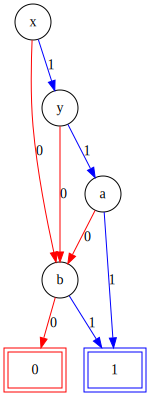

In [10]:
s.create_bdd()

In [11]:
s2 = create_proposition("""
x & y,
y | z
""")

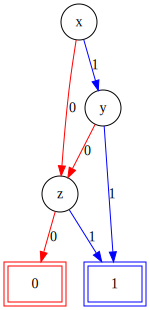

In [12]:
s2.create_bdd()

### Example 5 from page 66 of DSMM:

We can use the boolean propositions to determine the truthfulness of statements in a given statement. Note that a proposition like this will not be able to create a Binary Decision Diagram, thus if one uses equality in the proposition, you recieve back a more generic statement object as opposed to a proposition one.

In [13]:
s3 = create_proposition("""
a = (~a & b) | (a & ~b),
b = a | b
""")

In [14]:
evaluate(s3)

sat
[b = False, a = False]


[a == Or(And(Not(a), b), And(a, Not(b))), b == Or(a, b)]

### Truth Table Example:

You can use propositions to generate truth tables, letting you visualize correctly setting values. The truth table is returned from a proposition object as a dictionary. That dictionary can then be accessed by a string of comma-separated values (either true variable (x) or false (~x)).

In [15]:
s4 = create_proposition("""
x & ~y | (z & ~x)
""")

In [16]:
evaluate(s4)

sat
[y = False, x = True]


[Or(And(x, Not(y)), And(z, Not(x)))]

In [17]:
truth_table = s4.truth_table()

In [18]:
truth_table

{'x, y, z': 0,
 'x, y, ~z': 0,
 'x, ~y, z': 1,
 'x, ~y, ~z': 1,
 '~x, y, z': 1,
 '~x, y, ~z': 0,
 '~x, ~y, z': 1,
 '~x, ~y, ~z': 0}

In [19]:
truth_table['x, y, z']

0

In [20]:
truth_table['~x, ~y, z']

1

## Predicate Logic:

If we do predicate logic, we again use the Z3 solver system.

Syntax for our predicate logic:

#### Formulas ; Quantifiers : Constraints

You may forgo adding formulas and/or quantifiers, for ease of use. You must have constraints, otherwise your statement does no work.

##### Quantifiers:

Comma-separated

! -> For all.

? -> There exists.

in Domain -> Variable in following domain (Domain can be: Z -> Int, R -> Real).


##### Constraints:

Comma-separated

Variables and statements associated as you would expect, using =, >, >=, <, <=. 

You can also use functions to return a boolean, thus using a function call as a boolean constraint.


##### Functions:

Comma-separated

Name of variable -> any valid variable name will do.

Domain/Range -> can be Z (ints), R (real), or Bool.

We start by showing a fully defined predicate formula (that is, all variables a functions are given a type).

In [21]:
s5 = create_predicate("""
f:Z -> Bool; ?x in Z: f(x) 
""")

As you can see, we have defined some function f that maps from integers to booleans, and said that there exists some x in the set of integers such that f(x) returns true. When we ask Z3 to solve it, it will return an interpretation of the provided function that allows for the statement to be true:

In [22]:
solver = evaluate(s5)

sat
[x!6 = 0, f = [0 -> True, else -> True]]


So we see, it assigns f to be a function that returns true when provided with a 0 and then sets the x to be true.

We can now change the quantifier type to ask a forall as opposed to exists on the x, so now every x we pass must return true from f. Let's see how Z3 changes its answer:

In [23]:
s6 = create_predicate("""
f: Z -> Bool; !x in Z: f(x)
""")

In [24]:
solver = evaluate(s6)

sat
[f = [else -> True]]


We see that now it assigns f to always turn true, allowing the entire predicate to be true.

Let's do a few basic functions to show some other uses of constraints:

In [25]:
s7 = create_predicate("""
?x in Z : x > 0.5, x < 1.5
""")

In [26]:
solver = evaluate(s7)

sat
[x!13 = 1]


In [27]:
s8 = create_predicate("""
!y in R : y = 0
""")

In [28]:
solver = evaluate(s8)

unknown


Above is an example of the shortcomings of the Z3 system. It does not know how to prove that not all ys are equal to 0, so it returns unknown.

As we mentioned above, we can provide partial specifications to our constraints, but let the system define others. For example, I can use a function call without having specified it, or use a variable without explicitly defining it. The parser will attempt to infer the meaning behind the variable and assign it one. This is not a sure-fire system, so providing explicit specification will tend to be safer, though it is certainly easier to not always have to fully specify each variable and function.

In [29]:
s9 = create_predicate("""
?x in Z: f(x)
""")

In [30]:
solver = evaluate(s9)

sat
[x!6018 = 0, f = [0 -> True, else -> True]]


In [31]:
s10 = create_predicate("""
f: Z -> Bool; f(x)
""")

In [32]:
solver = evaluate(s10)

sat
[x = 0, f = [0 -> True, else -> True]]


Here we can see that in both situations, it has been able to infer the correct interpretations for the function and the variable type, and returned the same correct answer.

### Zero-Arity Functions:

Zero arity functions are supported in our boolean parser! You can provide the definition by simply forgoing the domain in your function specification, or, as before, let the system infer the type you are looking for:

In [33]:
s11 = create_predicate("""
f: -> Z; f() + 4 > 10
""")

In [34]:
evaluate(s11)

sat
[f = 7]


[And(f + 4 > 10, True)]

Notice that it looks like f is simply a variable. That is actually exactly right, as everything in Z3 is really a function, even variables.

In [35]:
s12 = create_predicate("""
?x in Z: g() < x
""")

In [36]:
evaluate(s12)

sat
[x!6019 = 0, g = -1]


[Exists(x, And(g < x, True))]

### Just Constraints
You can also simply write constraints with not pre-interpretations attached.

In [37]:
s13 = create_predicate("""
x > 4
""")

In [38]:
evaluate(s13)

sat
[x = 5]


[And(x > 4, True)]

And you can do it with function calls as well:

In [39]:
s14 = create_predicate("""
f() + 4 < 13, g(y)
""")

In [40]:
evaluate(s14)

sat
[f = 0, y = A!val!0, g = [A!val!0 -> True, else -> True]]


[And(g(y), And(f + 4 < 13, True))]

The above example shows an example of custom "Sorts", which are essentially domains (like integers or reals). One can see that is types y as A, then provides it some arbitrary value A!val!0, which maps to True when passed to g, thus making the predicate true.

### Shorthand Predicates:

You can also use the shorthand for quantifiers, applying only the quantifier (i.e., for all or exists) and the system  will create an interpretation (i.e. type) automatically, fitting the context you call it in. Below are a few examples.

In [41]:
s15 = create_predicate("""
!x: f(x)
""")

In [42]:
evaluate(s15)

sat
[elem!6020 = A!val!0, f = [else -> True]]


[ForAll(x, And(f(x), True))]

We interpret this as there exists some x, such that f(x) is true. When we evaluate, we set x's type equal to a custom type A (as mentioned earlier, this is a custom sort), then we make f map from A to in this case a boolean. Z3 can then do the rest of the working, setting x equal to some arbitrary A value, then mapping that A value to True in the function definition.

In [43]:
s16 = create_predicate("""
?x: 14 > x - 10
""")

In [44]:
evaluate(s16)

sat
[x!6027 = 0]


[Exists(x, And(x - 10 < 14, True))]

## Implications using Predicates:

One can also combine predicates using boolean logic (ands, ors, and implies). Simply place the relevant boolean action between two predicates. Note: because these symbols can also be used within the constraints of a single predicate, the parser may not be able to tell if you are applying these arguments as part of the constraints or part of the larger predicates argument. This being said, adding parentheses and more explicit typing (i.e., adding in quantifiers and function declarations) can help the system recognize between the two.

In [45]:
s17 = create_predicate("""
(s: Z -> Bool; ?x in Z : s(x)) => (s: Z -> Bool; ?x in Z : s(x + 1))
""")

In [46]:
evaluate(s17)

sat
[x!6029 = 0, s = [else -> True]]


[Implies(Exists(x, And(s(x), True)),
         Exists(x, And(s(x + 1), True)))]

In [47]:
s18 = create_predicate("""
(?x : S() => Q(x)) => ((S: -> Bool; S()) => ?x: Q(x))
""")

In [48]:
evaluate(s18)

sat
[S = False]


[Implies(Exists(x, And(Implies(S, Q(x)), True)),
         Implies(And(S, True), Exists(x, And(Q(x), True))))]